In [ ]:
"""Trying to figure out what is going on with the quartz random_10x10 trials where D-Indirect and G yield different results even though 
they should tehcnially give the same result

I wasn't able to find anything wrong using this notebook... so onto the next debugging idea
"""
import pandas as pd
from pathlib import Path
from typing import List, Union
import numpy as np
from influence.plotting import plot_joint_trajectory, PlotArgs
from influence.config import load_config

In [16]:
# Start with trial 4 for D-Indirect gen 0. Is G even being calculated correctly? Does G when computed from the joint trajectory match with G in the fitness csv?
fitness_df = pd.read_csv(
    '~/influence-shaping/results/10_29_2024/quartz/1_rover_1_uav/random_pois_10x10/IndirectDifferenceAutomatic/trial_4/fitness.csv'
)

In [17]:
class Fit:
    def __init__(self, team_fitness, rover_fitness, uav_fitness):
        self.team = team_fitness
        self.rover = rover_fitness
        self.uav = uav_fitness

def get_recorded_fitnesses(fitness_df: pd.DataFrame, team_id: Union[int|str], gen_id: int) -> Fit:
    if isinstance(team_id, str) and team_id == 'aggregated':
        return Fit(
            team_fitness=fitness_df['team_fitness_aggregated'][gen_id],
            rover_fitness=fitness_df['rover_0_'][gen_id],
            uav_fitness=fitness_df['uav_0'][gen_id]  
        )
    elif isinstance(team_id, int) and team_id >= 0 and team_id < 10:
        return Fit(
            team_fitness=fitness_df['team_fitness_'+str(team_id)][gen_id],
            rover_fitness=fitness_df['team_'+str(team_id)+'_rover_0'][gen_id],
            uav_fitness=fitness_df['team_'+str(team_id)+'_uav_0'][gen_id]
        )
    else:
        raise Exception(f"team id must either be int of a team or 'aggeregated' to indicate the aggregated team fitness. team_id is {team_id}")

In [18]:
joint_traj = pd.read_csv(
    '~/influence-shaping/results/10_29_2024/quartz/1_rover_1_uav/random_pois_10x10/IndirectDifferenceAutomatic/trial_4/gen_0/eval_team_0_joint_traj.csv'
)

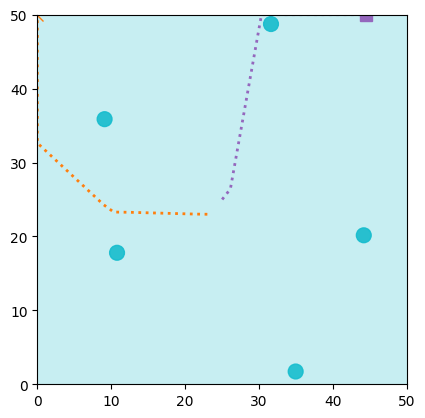

In [19]:
# Let's look at the joint trajectory here
plot_joint_trajectory(
    joint_traj_dir=\
        Path('~/influence-shaping/results/10_29_2024/quartz/1_rover_1_uav/random_pois_10x10/IndirectDifferenceAutomatic/trial_4/gen_0/eval_team_0_joint_traj.csv'),
    individual_colors=False,
    no_shading=False,
    plot_args=PlotArgs(
        title=None,
        output=None,
        xlim=None,
        ylim=None,
        xlabel=None,
        ylabel=None,
        silent=False
    )
)

In [20]:
def joint_trajectory_is_valid(joint_traj: pd.DataFrame) -> bool:
    valid = True
    # First, let's just make sure that there are the correct number of hidden pois
    column_names = joint_traj.columns.tolist()
    for name in column_names:
        if 'rover_poi' in name:
            print('ERROR: Found rover poi in joint trajectory')
            valid = False
        if 'hidden_poi_' in name:
            if int(name.split('_')[-2]) > 4:
                print('ERROR: Too many pois')
                valid = False

    expected_names = ['hidden_poi_'+str(i)+'_x' for i in range(5)] + ['hidden_poi_'+str(i)+'_y' for i in range(5)]
    for expected in expected_names:
        if expected not in column_names:
            print(f'ERROR: Missing label {expected} from joint trajectory')
            valid = False

    # Before going further, I'm going to make sure the pois don't somehow magically move throughout the episode
    for i in range(5):
        poi_x_t0 = joint_traj['hidden_poi_'+str(i)+'_x'][0]
        poi_y_t0 = joint_traj['hidden_poi_'+str(i)+'_y'][0]
        for s, (poi_x, poi_y) in enumerate(zip(joint_traj['hidden_poi_'+str(i)+'_x'][1:], joint_traj['hidden_poi_'+str(i)+'_y'][1:])):
            if poi_x != poi_x_t0 or poi_y != poi_y_t0:
                print(f"ERROR: Mismatch for poi {i} at step {s+1}")
                valid = False

    # Make sure that pois spawn within their respective boundaries
    poi_bounds = [
        {
            'low_x': 40.0,
            'high_x': 50.0,
            'low_y': 20.0,
            'high_y': 30.0
        },
        {
            'low_x': 26.18033988749895,
            'high_x': 36.180339887498945,
            'low_y': 39.02113032590307,
            'high_y': 49.02113032590307
        },
        {
            'low_x': 3.8196601125010545,
            'high_x': 13.819660112501055,
            'low_y': 31.755705045849467,
            'high_y': 41.75570504584947
        },
        {
            'low_x': 3.8196601125010474,
            'high_x': 13.819660112501047,
            'low_y': 8.24429495415054,
            'high_y': 18.24429495415054
        },
        {
            'low_x': 26.180339887498945,
            'high_x': 36.180339887498945,
            'low_y': 0.9788696740969272,
            'high_y': 10.978869674096927
        }
    ]
    for i in range(5):
        poi_x, poi_y = joint_traj['hidden_poi_'+str(i)+'_x'][0], joint_traj['hidden_poi_'+str(i)+'_y'][0]
        if poi_x > poi_bounds[i]['high_x'] or poi_x < poi_bounds[i]['low_x']:
            print(f"ERROR: poi x position is out of bounds")
            valid = False
        if poi_y > poi_bounds[i]['high_y'] or poi_y < poi_bounds[i]['low_y']:
            print(f"ERROR: poi y position is out of bounds")
            valid = False
    return valid

# No printouts, so we should be fine to continue with the assumption that pois don't move and we have the correct number of pois

In [21]:
# Let's step through the rover's path and see how close it got to the POI
# NOTE: Poi's capture radius is set to 1,000 so there should be a reward associated with each poi that is accounted for in G

def compute_G(joint_traj):
    poi_positions = [[joint_traj['hidden_poi_'+str(i)+'_x'][0], joint_traj['hidden_poi_'+str(i)+'_y'][0]] for i in range(5)]

    # First get the minimum distance of the rover to each poi
    min_dists = [None]*5
    for rover_x, rover_y in zip(joint_traj['rover_0_x'], joint_traj['rover_0_y']):
        for i, (poi_x, poi_y) in enumerate(poi_positions):
            dist = np.linalg.norm(np.array([rover_x, rover_y]) - np.array([poi_x, poi_y]))
            if min_dists[i] is None or dist < min_dists[i]:
                min_dists[i] = dist

    # Then compute the reward for each poi, and add them up to get G
    G = 0
    for dist in min_dists:
        G += 1/max(dist, 1.0)
    return G

def recorded_fitness_is_correct(joint_traj: pd.DataFrame, recorded_fitnesses: Fit, trial_id: int, team_id: int, gen_id: int) -> bool:
    correct = True

    G = compute_G(joint_traj)
    # Now compare this G with the fitnesses recorded in the csvs
    for fitness, name in zip([recorded_fitnesses.team, recorded_fitnesses.rover, recorded_fitnesses.uav], ['team', 'rover', 'uav']):
        if not np.isclose(G, fitness): # NOTE: I may have to replace this in the future with np.isclose()
            correct = False
            print(f"ERROR: G is not equal to the recorded fitness\n" + \
                f"G is {G}, fitness is {fitness}\n" + \
                f"Incorrect fitness is from {name}\n" + \
                f"trial_id: {trial_id} | team_id: {team_id} | gen_id: {gen_id}"
            )
    
    return correct

In [22]:
# Let's use these nice functions to check every team's joint trajectory in one trial
def trial_is_correct(trial_dir: Path, trial_id: int, gen_save_frequency: int, num_evaluation_teams: int, num_generations: int):
    correct = True

    fitness_dir = trial_dir/'fitness.csv'
    fitness_df = pd.read_csv(fitness_dir)

    for gen_id in list(range(num_generations))[::gen_save_frequency]:
        for team_id in range(num_evaluation_teams):
            jt_dir = trial_dir/('gen_'+str(gen_id))/('eval_team_'+str(team_id)+'_joint_traj.csv')
            joint_traj = pd.read_csv(jt_dir)
            recorded_fitnesses = get_recorded_fitnesses(fitness_df, team_id, gen_id)
            if not (joint_trajectory_is_valid(joint_traj) and recorded_fitness_is_correct(joint_traj, recorded_fitnesses, trial_id=trial_id, team_id=team_id, gen_id=gen_id)):
                correct = False
    
    # If an error is found, then this trial is not correct
    # If no error is found, then this trial is correct
    return correct

In [23]:
def all_trials_are_correct(config_dir: Path):
    correct = True

    # Get everything we need from the config
    config = load_config(config_dir)
    num_trials = config['experiment']['num_trials']
    gen_save_frequency = config['data']['save_trajectories']['num_gens_between_save']
    num_evaluation_teams = config['ccea']['evaluation']['multi_evaluation']['num_evaluations']
    num_generations = config['ccea']['num_generations']

    # Now check all the trials
    parent_dir = config_dir.parent
    for trial_id in range(num_trials):
        if not trial_is_correct(
            trial_dir=parent_dir/('trial_'+str(trial_id)),
            trial_id=trial_id,
            gen_save_frequency=gen_save_frequency,
            num_evaluation_teams=num_evaluation_teams,
            num_generations=num_generations
            ):
            correct = False
    
    return correct

In [24]:
def experiments_are_correct(config_dirs: List[Path]):
    error_found = False
    for config_dir in config_dirs:
        if not all_trials_are_correct(config_dir):
            error_found = True
    return not error_found

In [25]:
# Let's check this for the trials with D-Indirect first
check_d_indirect = all_trials_are_correct(
    config_dir=Path('~/influence-shaping/results/10_29_2024/quartz/1_rover_1_uav/random_pois_10x10/IndirectDifferenceAutomatic/config.yaml')
)

In [27]:
# Now check the trials that used G
check_g = all_trials_are_correct(
    config_dir=Path('~/influence-shaping/results/10_29_2024/quartz/1_rover_1_uav/random_pois_10x10/Global/config.yaml')
)

In [28]:
print(check_d_indirect, check_g)

True True


#### The following cells were helping me debug a problem that came from this notebook, NOT from the results or the influence library code

In [ ]:
# Investigating this discrepancy from IndirectDifferenceAutomatic

# ERROR: G is not equal to the recorded fitness
# G is 1.9344744964694005, fitness is 1.200821119854093
# Incorrect fitness is from team
# trial_id: 0 | team_id: 6 | gen_id: 0

# Let's see the joint trajectory in question
# Let's look at the joint trajectory here
joint_traj_dir = Path('~/influence-shaping/results/10_29_2024/quartz/1_rover_1_uav/random_pois_10x10/IndirectDifferenceAutomatic/trial_0/gen_0/eval_team_6_joint_traj.csv')
plot_joint_trajectory(
    joint_traj_dir=joint_traj_dir,
    individual_colors=False,
    no_shading=False,
    plot_args=PlotArgs(
        title=None,
        output=None,
        xlim=None,
        ylim=None,
        xlabel=None,
        ylabel=None,
        silent=False
    )
)

In [ ]:
# Let's grab the corresponding fitness
fit = get_recorded_fitnesses(
    fitness_df=pd.read_csv(Path('~/influence-shaping/results/10_29_2024/quartz/1_rover_1_uav/random_pois_10x10/IndirectDifferenceAutomatic/trial_0/fitness.csv')),
    team_id=6,
    gen_id=0
)
print(fit.team, fit.rover, fit.uav)

In [ ]:
# Now let's compute G
G = compute_G(joint_traj=pd.read_csv(joint_traj_dir))
G